This code uses the topic model's coherence to create and explore the use of the Louvain community within a graph. The topics extracted by the LDA algorithm and then the coherence pipeline is used to explore the dual state of the community. 

In [3]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx


import gensim
from gensim.matutils import argsort
from gensim.models.coherencemodel import CoherenceModel
from gensim.topic_coherence import segmentation
from gensim.topic_coherence import probability_estimation
from gensim.topic_coherence import direct_confirmation_measure
from gensim.topic_coherence.aggregation import arithmetic_mean

from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

import subprocess
import time
from yappyChuck import Client

#set the messaging up for all. Fix to 5005. 
client = Client()

In [4]:
df = pd.read_csv('../enmi.csv')

stoplist = stopwords.words('english')
#stoplist += ['rt', 'dm', 'ht']#remove Twitter specific language
stoplist += stopwords.words('french')

vect = CountVectorizer(stop_words=stoplist, 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
# Fit and transform
X = vect.fit_transform(df.text)

#Convert the sparse matrix to a corpus
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [5]:
model = gensim.models.LdaModel(corpus, id2word = dict((v, k) for k, v in vect.vocabulary_.items()), 
                               num_topics=5)

In [6]:
#get the topis from the model
topics = [argsort(topic, topn=5, reverse=True) for topic in model.get_topics()]
topics

[array([124,  42, 155, 185, 375]),
 array([124, 152, 155, 178,  50]),
 array([124, 155, 151, 268,  46]),
 array([124, 155, 258, 377, 323]),
 array([124, 155,  50, 178, 140])]

Echoing the coherence score pipeline. The process is stopped at the probability so that we can investigate it as a data object. 

In [7]:
segmented_topics = segmentation.s_one_pre(topics)
print(segmented_topics)
result = probability_estimation.p_boolean_document(corpus, segmented_topics)

[[(42, 124), (155, 124), (155, 42), (185, 124), (185, 42), (185, 155), (375, 124), (375, 42), (375, 155), (375, 185)], [(152, 124), (155, 124), (155, 152), (178, 124), (178, 152), (178, 155), (50, 124), (50, 152), (50, 155), (50, 178)], [(155, 124), (151, 124), (151, 155), (268, 124), (268, 155), (268, 151), (46, 124), (46, 155), (46, 151), (46, 268)], [(155, 124), (258, 124), (258, 155), (377, 124), (377, 155), (377, 258), (323, 124), (323, 155), (323, 258), (323, 377)], [(155, 124), (50, 124), (50, 155), (178, 124), (178, 155), (178, 50), (140, 124), (140, 155), (140, 50), (140, 178)]]


## Louvain Clustering

https://python-louvain.readthedocs.io/en/latest/ pip install python_louvain

Use Louvain clustering to get the graphs using the words as a base to create the communities.

## A simple Louvain graph from the Probabilities

This work uses a simple Louvain graph to provide a simple graph to explore. 

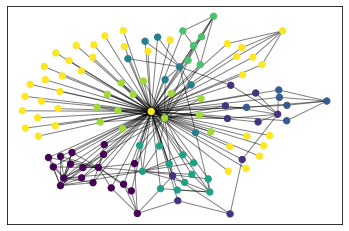

In [8]:
# load the graph
G = nx.Graph()

rt = result.index_to_dict()
for r in rt:
    G.add_node(r)
    for t in rt[r]:
        G.add_edge(r,t)

#compute the best partition
partition = community_louvain.best_partition(G)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Let's get the modularity out of the graph. 

In [11]:
modular = community_louvain.modularity(partition, G)
print(modular)

0.4667598383237146


Now that we have the edges from the graph, use them to identify the communities to which they might also belong algorithmically. 

Very much a todo object but two options here:

1. Have the partition a chord or similar and the edges can have their identities mapped to the partitions. Sonification of the algorithmic communities. 

2. Use the partition chord again but map the numbers to their words and to a score from that. The score could be by word _or_ it might be through a concept. 

This looks to apply different models to the new digital object so that it can be discovered. Re-uses the central numbers to create new objects. 

In [9]:
for edge in G.edges:
    if partition[edge[0]] == partition[edge[1]]:
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], .5)
        client.send(msg)
    else:
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], .2)
        client.send(msg)
    time.sleep(0.5)

(258, 33)
(258, 34)
(258, 35)
(258, 72)
(258, 30)
(258, 31)
(33, 323)
(33, 155)
(33, 124)
(34, 323)
(34, 124)
(35, 50)
(35, 124)
(72, 50)
(72, 124)
(30, 50)
(30, 124)
(31, 50)
(31, 155)
(31, 124)
(323, 75)
(75, 152)
(75, 124)
(377, 1)
(377, 98)
(377, 36)
(377, 69)
(377, 85)
(1, 124)
(98, 155)
(98, 124)
(36, 124)
(69, 152)
(69, 124)
(85, 124)
(42, 97)
(42, 79)
(42, 80)
(42, 84)
(42, 88)
(42, 90)
(42, 91)
(42, 92)
(42, 140)
(42, 178)
(42, 50)
(42, 124)
(97, 124)
(79, 155)
(79, 124)
(80, 185)
(80, 124)
(84, 185)
(84, 124)
(88, 185)
(88, 155)
(90, 124)
(91, 185)
(91, 155)
(91, 124)
(92, 155)
(92, 124)


KeyboardInterrupt: 

In [10]:
# re-run but focus on the edges
for edge in G.edges:
    if partition[edge[0]] == partition[edge[1]]:
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], .2)
        client.send(msg)
    else:
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], .5)
        client.send(msg)
    time.sleep(0.5)

KeyboardInterrupt: 

## Weighted Graphs for the Probabilities

Use the Louvain method on the communities in the topics and using the Jaccard Similarity  as the weight. 

Sort of following this to explore the data:
https://orange3.readthedocs.io/projects/orange-visual-programming/en/latest/widgets/unsupervised/louvainclustering.html

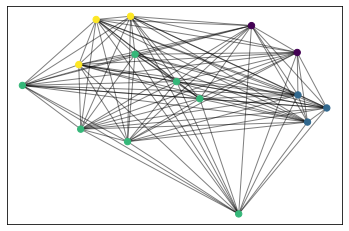

In [11]:
G = nx.Graph()

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

rt = result.index_to_dict()
for r in rt:
    G.add_node(r)
    #iterate over sets
    for t in rt:
        if t != r:
            G.add_edge(r,t)

for r in rt:
    G.add_node(r)
    #iterate over sets
    for t in rt:
        if t != r:
            #add in the weight to the edge
            G[r][t]['weight'] = jaccard_similarity(rt[r], rt[t])
            #T
nx.k_nearest_neighbors(G, weight='weight')

#compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
#nx.k_nearest_neighbors(G, weight='weight')
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [12]:
#let's calculate the modularity of the community partitions
modular = community_louvain.modularity(partition, G)
print(modular)

0.4566208935985331


In [18]:
import random
#make the edge time more random against the intercommunity edges.
for edge in G.edges:
    
    if partition[edge[0]] == partition[edge[1]]:
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], .5)
        client.send(msg)
        time.sleep(0.4)
    else:
        #modular can go below 0. Ought to catch
        t = random.uniform(0, modular)
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], .2)
        client.send(msg)
        time.sleep(t)

KeyboardInterrupt: 

In [21]:
#change the duration based on weight
for edge in G.edges:
    weight = G.get_edge_data(*edge)['weight']
    print(weight)
    if partition[edge[0]] == partition[edge[1]]:
        msg = "weight_edge:{0}:{1}:{2}:{3}".format(partition[edge[0]], partition[edge[1]],weight, 0.3)
        client.send(msg)
        time.sleep(0.4)
    else:
        #modular can go below 0. Ought to catch
        t = random.uniform(0, modular)
        msg = "weight_edge:{0}:{1}:{2}".format(partition[edge[0]], partition[edge[1]], weight, t)
        client.send(msg)
        time.sleep(t)

0.2857142857142857
0.0
0.0
0.0
0.0
0.0
0.0
0.23529411764705882
0.0
0.0
0.0
0.06451612903225806
0.061224489795918366
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1111111111111111
0.0
0.034482758620689655
0.030612244897959183
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.09090909090909091
0.0
0.03225806451612903
0.05102040816326531
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [ ]:
#get the weights from the graph data
for edge in G.edges:
    print(edge[0])
    print(edge[1])
    print(G.get_edge_data(*edge)['weight'])

Import the midi data here to separate it out. 

In [73]:
from midiutil import MIDIFile
import math

#let's set up midi stuff
track    = 0
channel  = 0
time     = 0    # In beats
duration = 1    # In beats
tempo    = 120   # In BPM
volume   = 62  # 0-127, as per the MIDI standard

#num_tracks = 16
#MyMIDI = MIDIFile(num_tracks)  
#MyMIDI.addTempo(track, time, tempo)
num_tracks = 4
communitiesMIDI = MIDIFile(num_tracks)  
communitiesMIDI.addTempo(track, time, tempo)

#MyMIDI.addNote(track, channel, frequency, time, duration, volume)

In [66]:
def edge_note (edge):
    '''
       Simple calculation for now to increment by one
    '''
    base_note = 60
    return base_note + edge

Here we use the communities for the nodes as the sonification. The nodes are mapped to their communities in a set of pairs, along the lines of source/target in IPs. 

In [31]:
for edges in G.edges:
    #time = math.floor(time) + 1
    time += 0.5
    for edge in edges:
        note = edge_note(partition[edge])
        #increment time here but it is a challenge. 
        time += 0.1
        communitiesMIDI.addNote(track, channel, note, time, 0.2, volume)
        
with open("communitiesnodes.mid", 'wb') as f:
    communitiesMIDI.writeFile(f)

This uses volume as the edge weight. The quieter the following part, the weaker. May be one for spatial sonification but perhaps using it for degree work? Challenge is directionality between the nodes.  

In [74]:
for edges in G.edges:
    time += 0.5
    for edge in edges:
        note = edge_note(partition[edge])
        #increment time here but it is a challenge. 
        time += 0.1
        if edge == edges[1]: 
            volume  = int(math.floor(volume * weight['weight']))
            communitiesMIDI.addNote(track, channel, note, time, 0.2, volume)
            volume = 62
        else:
            communitiesMIDI.addNote(track, channel, note, time, 0.2, volume) 
        
with open("communitiesedgesound.mid", 'wb') as f:
    communitiesMIDI.writeFile(f)

Here we turn to rhythm to create the edges. A challenge is how to map the weight which can be any number of things. In this example, we know it is Jaccard similarity so that we can boost it by a fixed number. May need other strategies if we are talking  about summing that Gephi does. 

In [61]:
for edges in G.edges:
    time = math.floor(time) + 1
    #based on the weighting given in the graph
    weight = G.get_edge_data(*edges)
    #time += 1
    for edge in edges:
        note = edge_note(partition[edge])
        #increment time here but it is a challenge. 
        time += 0.5
        beat_length = weight['weight']
        # we'll place a base beat. 
        if beat_length == 0.0: beat_length =  0.1
        beat_length = 1.0 - beat_length
        for i in range(partition[edge]):
            #time += 0.1
            communitiesMIDI.addNote(track, channel, note, time, beat_length, volume)
        
with open("communitiesedges.mid", 'wb') as f:
    communitiesMIDI.writeFile(f)

{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.25}
0.75
{'weight': 0.25}
0.75
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.04081632653061224}
0.9591836734693877
{'weight': 0.04081632653061224}
0.9591836734693877
{'weight': 0.5}
0.5
{'weight': 0.5}
0.5
{'weight': 0.375}
0.625
{'weight': 0.375}
0.625
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.0}
0.9
{'weight': 0.23529411764705882}
0.7647058823529411
{'weight': 0.23529411764705882}
0.7

Here we extract the communities into notes with the duration and duration model based on the community itself.The note length is based on the volume. A warmer chord is useful here to suggest a sound scape

In [20]:
c = {}

for edges in G.edges:
    for edge in edges:
        if partition[edge] in c:
            c[partition[edge]] += 1
        else:
            c[partition[edge]] = 1

for k,v in c.items():
    note = edge_note(k)
    dur = math.floor(c[k]/10)
    time += 1
    communitiesMIDI.addNote(track, channel, note, time, dur, volume+dur)
        
with open("communitiesoverview.mid", 'wb') as f:
    communitiesMIDI.writeFile(f)

4
6
4
8
3
